# SN Fits as Reference

Set of SNooPy fits using all and grJH bands, and Gaussian Process fits of J and H bands (independently).

In [54]:
import os
import glob

import snpy
import numpy as np
import pandas as pd

import scipy
import george
from copy import deepcopy
from peakutils import peak

from multiprocessing import Pool

print(f'SNooPy version: v{snpy.__version__}')

SNooPy version: v2.6.0


## SN Parameters

In [40]:
def get_parameter(sn, parameter, include_sys=False):
    """Obtains the value of the given parameter and
    the total (systematics + statistical) uncertainty
    of a fitted SN.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    parameter: str
        Parameter to extract.
    include_sys: bool
        If `True`, systematic uncertainties are 
        included.
        
    Returns
    =======
    value: float
        Value of the parameter.
    err: float
        Total uncertainty in the parameter. 
    """
    
    value = sn.parameters[parameter]
    stats_err = sn.errors[parameter]
    if include_sys:
        sys_err = sn.systematics()[parameter]
    else:
        sys_err = 0.0
    err = np.sqrt(stats_err**2 + sys_err**2)
    
    return value, err

def calc_colour_stretch(sn, band1='g', band2='r', include_sys=False):
    """Calculates the colour stretch for the given bands.
    See Burns et al. (2014) for more information.
    
    **Note:** Colour = band1 - band2
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object. Must be fitted before.
    band1: str
        First band for the colour stretch.
    band2: str
        Second band for the colour stretch.
    include_sys: bool
        If `True`, systematic uncertainties are 
        included.
        
    Returns
    =======
    colour_stretch: float
        Colour stretch for the given bands.
    colour_stretch_err: float
        Error of the colour stretch parameter.
    """    
    time = np.arange(sn.Tmax-3, sn.Tmax+50, 0.01)
    mag1, err1, mask = sn.model(band1, time)
    mag2, err2, mask = sn.model(band2, time)
    colour = mag1 - mag2
    
    c_max_ind = peak.indexes(colour, thres=.3, min_dist=10)[0]
    c_max = time[c_max_ind]
    Tmax, Tmax_err = get_parameter(sn, 'Tmax', include_sys)
    colour_stretch = (c_max - Tmax)/30
    # assume same err as Tmax
    colour_stretch_err = Tmax_err/30
    
    return colour_stretch, colour_stretch_err

## SNooPy fit functions

In [62]:
def fit_sn(sn, bands, model, include_sys=False):
    """Fits gr-bands light curves of a SN with SNooPy.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    bands: list
        Bands used for the fit.
    model: str
        SNooPy model to use for the fit.
    include_sys: bool
        If `True`, systematic uncertainties are 
        included.

    Returns
    =======
    sn object and dictionary with light-curve parameters.
    """
    models = ['max_model', 'EBV_model2']
    assert model in models, f'model {model} not supported ({models})'
    sn.choose_model(model)
    sn.fit(bands)
    
    params_dict = {'name':sn.name, 
                   'z':sn.z,
                   'ra':sn.ra,
                   'dec':sn.decl}
    
    if model=='max_model':
        st, st_err = get_parameter(sn, 'st', include_sys)
        params_dict.update({'st':st, 
                            'st_err':st_err})
        s_gr, s_gr_err = calc_colour_stretch(sn, 
                                     include_sys=include_sys)
        params_dict.update({'s_gr':s_gr, 
                            's_gr_err':s_gr_err})
        for band in bands:
            mmax, mmax_err = get_parameter(sn, f'{band}max', 
                                           include_sys)
            params_dict.update({f'{band}max':mmax, 
                                f'{band}max_err':mmax_err})
        
    elif model=='EBV_model2':
        mu, mu_err = get_parameter(sn, 'DM', include_sys)
        params_dict.update({'mu':mu, 
                            'mu_err':mu_err})
    
    return sn, params_dict

def full_fit(sn_file):
    """Fits a SN with different configurations.
    
    Parameters
    ==========
    sn_file: str
        SN file in SNooPy format.
        
    Results
    =======
    List of dictionaries with light-curve parameters. 
    """
    bands_list = [list('gr'), list('grJ'), list('gr')]
    models = ['max_model', 'max_model', 'EBV_model2']
    
    sn = snpy.import_lc(sn_file)
    
    params_list = []
    for bands, model in zip(bands_list, models):
        sn_copy = deepcopy(sn)
        try:
            sn_copy, params_dict = fit_sn(sn_copy, 
                                          bands, 
                                          model)
            params_list.append(params_dict)
            output_file = os.path.join(OUTPUT_DIR, 
                                       f'{sn.name}_{bands}_{model}.snpy')
            sn.save(output_file)
        except:
            params_list.append(np.nan)
    
    return params_list

In [63]:
PROCESSES = 8
OUTPUT_DIR = 'test_fits'

with open('reference_files.txt') as ref_file:
    sn_files = ref_file.read().splitlines()

results = Pool(PROCESSES).map(full_fit, (sn_file for sn_file in sn_files))

In [ ]:
configs = ['gr_max_model', 'grJ_max_model', 'gr_EBV_model2']

for i, config in enumerate(configs):
    df_list = []
    for sn_results in results:
        if type(sn_results[i])==dict:
            sn_df = pd.DataFrame(sn_results[i], index=[0])
            df_list.append(sn_df)
    
    df = pd.concat(df_list)
    df.to_csv(f'{config}.csv', index=False)

Jmax (option 1): 15.4183 +/- 0.0279
Jmax (option 2): 15.4183 +/- 0.0279


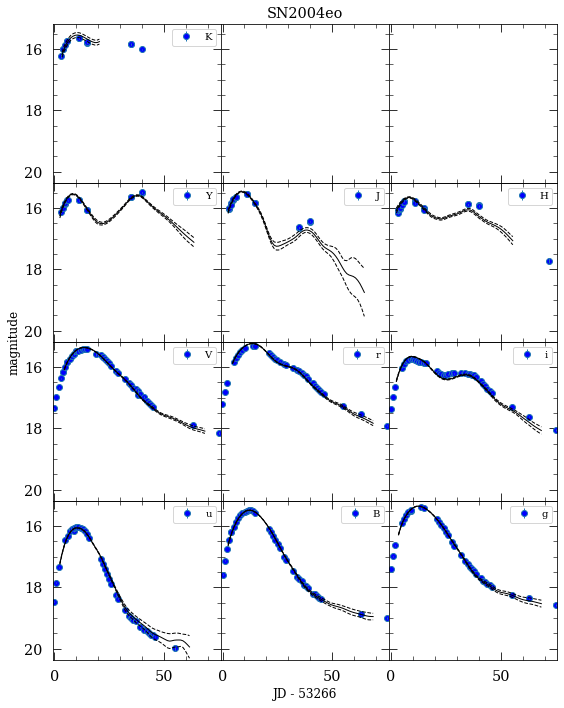

In [67]:
sn = snpy.import_lc('csp_data/SN2004eo_snpy.txt')
sn.choose_model('max_model')
sn.fit()

# how to get the parameters
Jmax1, Jmax_err1 = get_parameter(sn, 'Jmax')
Jmax2, Jmax_err2 = sn.get_max('J', restframe=1, deredden=1)[1:3]
print(f'Jmax (option 1): {Jmax1:.4f} +/- {Jmax_err1:.4f}')
print(f'Jmax (option 2): {Jmax2:.4f} +/- {Jmax_err2:.4f}')

In [92]:
configs = ['gr_max_model', 'grJ_max_model', 'gr_EBV_model2']

for i, config in enumerate(configs):
    df_list = []
    for sn_results in results:
        if type(sn_results[i])==dict:
            sn_df = pd.DataFrame(sn_results[i], index=[0])
            df_list.append(sn_df)
    
    df = pd.concat(df_list)
    df.to_csv(f'{config}.csv', index=False)